# AT&T CNN
This example is trying the Databse of face from AT&T Lab Cambridge, using CNN to perform Face-recognitions
http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

Tbh, the current model is obviously overfitted, but since this dataset doesn't provide a sufficient amount of data. I didn't spent much time on it.

## Imports

In [1]:
from IPython.display import Image
from PIL import Image as pilImage
import tensorflow as tf
import numpy as np
import os
import time
import math
from datetime import timedelta
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
import ATT as att
from ATT import IMAGE_SIZE, NUM_CHANNELS, NUM_CLASSES
att.maybe_download_and_extract()
# Get Training data
train_image, train_cls, train_cls_one_hot = att.get_data(isTraining = True)
# Get Test data
test_image, test_cls, test_cls_one_hot = att.get_data(isTraining = False)

# img = Image.fromarray(t, 'L')
# img.show()

Data has already been extracted in previous session.
Training data acquire successfully!
The Training-set contain [320] images
Training data acquire successfully!
The Training-set contain [80] images


## Setting Variables

In [3]:
# hyperparameters
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Learning rate
learning_rate = 1e-4

### Placeholder variables

Everytime we execute the TensorFlow computational graph, we can feed different values to the Placeholder variables. These Placeholder variable are multi-dimensional array called <b>tensor</b> and the data-type is set to <b>float32</b>. 

<font color="red">**None means it can hold an arbitrary number of images.</font>
<br>The images input shape: [None, img_size, img_size, num_channels]
<br>- Each image being <b>img_size</b> pixels high and <b>img_size</b> pixels wide and with <b>num_channels</b> colour channels.
<br>The labels shape: [None, num_classes]
<br>The class shape: [None]

In [4]:
class_names = range(1,41)
# TensorFlow expect 4-dim input X, so we have to reshape x
# Output: [num_images, img_height, img_width, num_channels]
# Note that all input is square, thus, img_height == img_width == img_size
# num_images can be inferred automatically by using -1 
x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS], name='x')

# Label y associated with X 
# Output: [arbitrary, num_classes]
# 10 classes for eachd digit in this case
# Each example's class is represent in vector e.g. For class 5 = [0,0,0,0,0,1,0,0,0,0]
y_true = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name='y_true')

# Class-number y associated with X 
# Output: [arbitrary]
# Each example's class is represent in number e.g. [5]
y_true_cls = tf.argmax(y_true, dimension=1)

### Helper Function
In ipython there is execution sequence, so all helper function should be execute before proceed. Different from previous practice, try to modularise some helper-functions are grouped and placed in <b>/helper</b>.

**Note that the initialization is not actually done at this point, it defines the TensorFlow graph.

In [5]:
import helper.cnn_layer as cnn
import helper.plotting as plot

plotting = plot.Plotting(NUM_CLASSES, NUM_CHANNELS, class_names)

### Plotting some examples from training-set

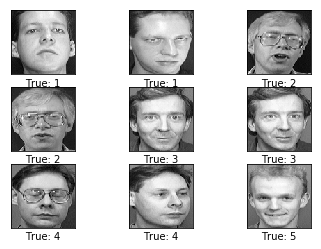

In [6]:
# Get the first images from the test-set.
images = test_image[0:9]
# Get the true classes for those images.
cls_true = test_cls[0:9]
# Plot the images and labels using our helper-function above.
plotting.plot_images(images=images, cls_true=cls_true, smooth=False)

### Plotting some distorted images

In [7]:
import helper.image_distortion as imd

distorted_images = imd.pre_process(images=x, training=True)

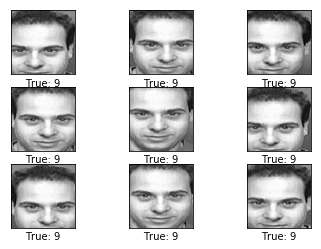

In [26]:
# Try to print some distorted image created with Helper-function pre_process() above
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plotting.plot_images(images=result, cls_true=np.repeat(cls_true, 9))

def get_test_image(i):
    return test_image[i, :, :, :], test_cls[i]

img, cls = get_test_image(16)
plot_distorted_image(img, cls)

### Helper-function - Get a random training-batch
Batch gradient descent is used here to avoid the model using all image at once. Small batch of images is used in each iteration by the optimizer.

In [9]:
train_batch_size = 128

def random_batch():
    # Number of images in the training-set.
    num_images = len(train_image) 

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = train_image[idx, :, :, :]
    y_batch = train_cls_one_hot[idx, :]

    return x_batch, y_batch

### Helper-functions - Calculating classifications
This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [10]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_one_hot, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

### Helper-function - Predict cls

In [11]:
def predict_cls_test():
    return predict_cls(images = test_image,
                       labels = test_cls_one_hot,
                       cls_true = test_cls)

### Helper-functions for the classification accuracy
This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4. The function also returns the number of correct classifications.

In [12]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the performance
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [13]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plotting.plot_example_errors(test_image=test_image, test_cls=test_cls, cls_pred=cls_pred, correct=correct)
        #plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plotting.plot_confusion_matrix(test_cls=test_cls, cls_pred=cls_pred)
        #plot_confusion_matrix(cls_pred=cls_pred)

## Architecture (CNN part)
This part is the implementation of the whole CNN feeding AT&T dataset to identify 40 classes of faces.

CNN-Architecture: <br>
Conv1 - Conv2 - Flatten - FC1 - FC2 - Output(Softmax)

In [14]:
layer_conv1, weights_conv1 = cnn.new_conv_layer(input=x,
                   num_input_channels=NUM_CHANNELS,
                   filter_size=filter_size1,
                   num_filters=num_filters1)

In [15]:
layer_conv2, weights_conv2 = cnn.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2)

In [16]:
layer_flat, num_features = cnn.flatten_layer(layer_conv2)

In [17]:
layer_fc1 = cnn.new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size)

In [18]:
layer_fc2 = cnn.new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=NUM_CLASSES,
                         use_relu=False)

In [19]:
print layer_fc2

Tensor("add_3:0", shape=(?, 40), dtype=float32)


In [20]:
# Class vector e.g. For class 5 = [0,0,0,0,0,1,0,0,0,0] 
y_pred = tf.nn.softmax(layer_fc2)
# Use argmax to convert y from class vector to class labels e.g. 5
y_pred_one_hot = tf.argmax(y_pred, dimension=1)

## Architecture (Optimisation Part)

### Cost-function to be optimised
We want the model to perform better at classifying the input images, this can be achieve by updating the weights of all layers. But first, we have to measure how well the model currently performs by comparing <b>y_pred</b> (Prediected output) to <b>y_true</b> (Actual output).

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to <font color="red">minimize the cross-entropy</font> so it gets as <font color="red">close to zero</font> as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. Note that <font color="red">the function calculates the softmax internally</font> so we must use the output of <b>layer_fc2</b> directly rather than <b>y_pred</b> which has already had the softmax applied.


In [21]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
# Using Logistic Cost Function
# - [y * log(h(x)) + (1-y) * log(1-h(x))]
# A cost is output for each image
# Output: [num of image,]
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
# Computes the mean of all cost, resulting a single value
cost = tf.reduce_mean(cross_entropy)
# Collecting accuracy for TensorBoard
tf.summary.scalar("cost", cost)

<tf.Tensor 'cost:0' shape=() dtype=string>

### Optimization Method
AdamOptimizer which is an advanced form of Gradient Descent we can use for minimise the cost.
<br>
**Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=global_step)

### Performance Measures
We need a few more performance measures to display the progress to the user.
This is a vector of booleans whether the predicted class equals the true class of each image.

In [23]:
# Vector of booleans whether the predicted class equals the true class of each image.
# Output: [num of image,]
correct_prediction = tf.equal(y_pred_one_hot, y_true_cls)
# Cast booleans to floats, False = 0, True = 1
# Calculate the average of these number
# Output: float32
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Collecting accuracy for TensorBoard
tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

### Saver
Save variables of the neural network to reloaded quickly without having to train the network again.
<br>Doc: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/04_Save_Restore.ipynb

**Note that nothing is actually saved at this point, which will be done further below.

In [24]:
saver = tf.train.Saver()

## Main (Execute)

In [25]:
# Create TensorFlow Session to execute the TensorFlow graph
session = tf.Session()
# Collecting accuracy for TensorBoard
# Summaries such as scalars can be seen by running the command below
# tensorboard --logdir="./log"
# http://192.168.0.150:6006
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./log', session.graph)
# Initialise weights and bias
#session.run(tf.global_variables_initializer())

### Executing-function - Perform optimization iterations
This function is called to execute the training process of CNN. A number of optimization iterations so as to gradually improve the variables of the network layers. Each iteration, new batch of data is selected from the training-set and TensorFlow executes the optimizer using them. 

Input:<br>
num_iterations - Number of optimization iterations<br>
Output:<br>
None<br>
*weights is updated with-in the model and message of <b>Training Accuracy</b> is printed every 100 iterations

In [27]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch - batch of image
        # y_true_batch - labels of x_batch
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # !!! Add [merged, opt] for TensorBoard !!! Very Important, Order has no effect
        i_global, summary, _ = session.run([global_step, merged, optimizer], feed_dict=feed_dict_train)
        # Add summary to TensorBoard
        writer.add_summary(summary, i)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Restore or initialize variables
Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If you want to restart the training of the neural network, you have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [28]:
save_dir = 'checkpoints/'
# Create directory if not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'att_cnn')

# Try to restore the latest checkpoint. 
# If checkpoint doesn't exist or TensorFlow graph has been modified, exception will raise.
# When exception appears, initialise will be made
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialise all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
('Restored checkpoint from:', u'checkpoints/att_cnn-1000')


In [30]:
optimize(num_iterations=900)

Global Step:      1, Training Batch Accuracy:   1.6%
Saved checkpoint.
Time usage: 0:00:02


Accuracy on Test-Set: 2.5% (2 / 80)
Example errors:


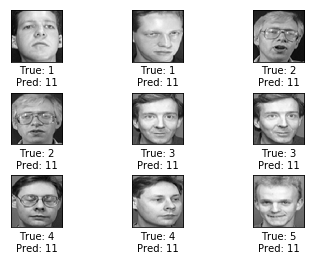

In [29]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=False)